In [1]:
import os
os.system('pip install -U -r requirements.txt')

import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.tree import export_graphviz
import pydotplus


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/nbuser/anaconda3_420/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/nbuser/anaconda3_420/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


Text(0,0.5,'cell voltage [V]')

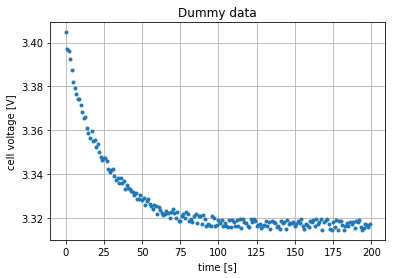

In [2]:
def model(X, r0, r1, c1, r2, c2):
    """Dual polarisation model of battery"""
    t  = X[:,0]
    i  = X[:,1]

    voltage = ocv - i*r0 \
                  - i*r1*(1 - np.exp(-t/(r1*c1))) \
                  - i*r2*(1 - np.exp(-t/(r2*c2)))
    return voltage
            

def model2(X, r0, r1, c1):
    """R-RC model of battery"""
    t  = X[:,0]
    i  = X[:,1]
    voltage = ocv - i*r0 \
                  - i*r1*(1 - np.exp(-t/(r1*c1)))
    return voltage

# Create some dummy data to test models

time = np.arange(200)
I    = 150*np.ones((200,1)) + np.random.random((200,))*10

X_in = np.c_[time, I]

# Arbitrary parameters to generate dummy data
R0 = 5e-3; 
R1 = 5e-4; 
C1 = 5e4; 
R2 = 5e-5;  
C2 = 5e4; 

ocv = 4.2
voltage = model(X_in, R0, R1, C1, R2, C2) + np.random.random((200,))*0.01/2

plt.plot(time,voltage, '.')
plt.title('Dummy data')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('cell voltage [V]')


,Actual value,Fitted value
R0,0.00500,0.004986
R1,0.00050,0.000491
C1,50000.00000,52837.669519
R2,0.00005,0.000059
C2,50000.00000,56970.850731


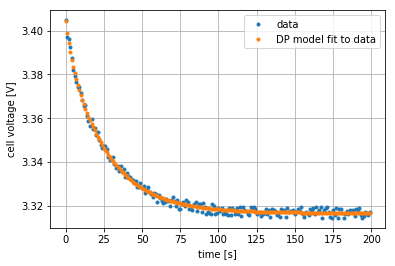

In [3]:
# Fitting Dual polarisation model to dummy data
ini = np.array([R0, R1, C1, R2, C2])*0.5

popt, pcov = curve_fit(model, X_in, voltage, p0=ini, bounds=(0, np.Inf))

plt.plot(time, voltage, '.',label='data')
plt.plot(time, model(X_in, *popt), '.', label='DP model fit to data')
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('cell voltage [V]')

df   = pd.DataFrame(np.c_[[R0, R1, C1, R2, C2], popt], ['R0', 'R1','C1', 'R2', 'C2'],
                    columns=['Actual value', 'Fitted value'])

df

,Actual value,Fitted value
R0,0.0050,0.005016
R1,0.0005,0.000517
C1,50000.0000,47296.154505


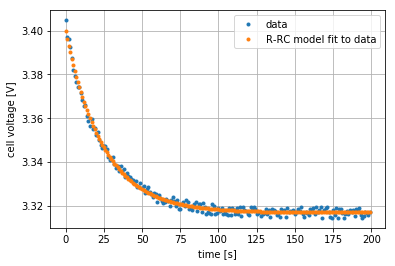

In [4]:
# fitting R-RC model to dummy data

ini = np.array([R0, R1, C1])*2

popt, pcov = curve_fit(model2, X_in, voltage, p0=ini, bounds=(0, np.Inf))


plt.plot(time, voltage, '.', label='data')
plt.plot(time, model2(X_in, *popt), '.', label='R-RC model fit to data')
plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('cell voltage [V]')

df   = pd.DataFrame(np.c_[[R0, R1, C1], popt], ['R0', 'R1','C1'],
                    columns=['Actual value', 'Fitted value'])

df

    Fitted parameters  Variance of fit
R0           0.000550     3.389551e-13
R1           0.000045     9.248834e-13
C1       27916.767053     1.203562e+06
R2           0.000654     2.313788e-11
C2       47267.183614     1.220304e+05


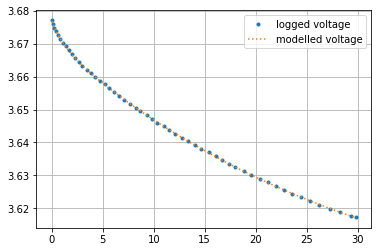


 RMSE: 0.00011082013719268678


In [5]:
# Working with real data

df = pd.read_csv('docs/data.txt', delimiter='\t')
df.columns = ['time', 'current', 'voltage']

time = df['time'] - df['time'][0]
current = -df['current']
voltage = df['voltage']

ocv = 3.75

X_data = np.c_[time, current]

# Ballpark estimates
ini = np.array([0.0005, 0.0001, 10000, 0.0001, 100000])

popt, pcov = curve_fit(model, X_data, voltage, p0=ini, bounds=(0, np.Inf))

print(pd.DataFrame(np.c_[popt.T, np.diag(pcov).T], ['R0', 'R1','C1', 'R2', 'C2'], \
                   columns=['Fitted parameters', 'Variance of fit']))

plt.plot(time, voltage, '.', label='logged voltage')
plt.plot(time, model(X_data, *popt), ':', label='modelled voltage')
plt.grid()
plt.legend()
plt.show()

error = voltage - model(X_data, *popt)
print('\n RMSE:', np.sqrt(np.mean(error**2)))

In [6]:
# Demonstration of failure of machine learning
# Fit the model to logged data

X_train = X_data

X = np.array(X_train)
y = np.array(voltage)

tree = DecisionTreeRegressor()

tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

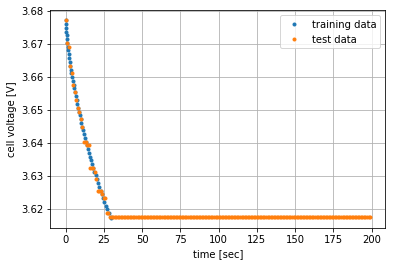

In [7]:
# Run the model on a synthetic data which has a very long current pulse

time = np.arange(200)
I    = 150*np.ones((200,1)) + np.random.random((200,1))*10

X_test = np.c_[time, I]

v_predict    = tree.predict(X_test)
v_predict_rf = tree.predict(X_test) 
plt.plot(X_train[:,0], voltage, '.', label='training data')
plt.plot(X_test[:,0], v_predict, '.', label='test data')
plt.xlabel('time [sec]')
plt.ylabel('cell voltage [V]')
plt.grid()
plt.legend()
plt.show()



In [8]:
dot_data = export_graphviz(
            tree,
            out_file=None,
            feature_names=['time', 'current'],
            class_names=['voltage'],
            rounded=True,
            filled=True
        )

graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('docs/visualise_decision_tree.png')


True